<a href="https://colab.research.google.com/github/VinoJose/Tensorflow/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Creating Helper functons
In previous notebooks, we have created a series of helper functions to do different tasks, let's download them.

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-01-19 12:19:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-01-19 12:19:39 (94.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food classes: working with less data
Our goal is to beat original 101 Food101 paper with 10% of training data, let's download it.

The data we are using comes from original Food101 dataset but has been preprocessed with image_data__modification notebook.
https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb 

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

--2022-01-19 12:19:41--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.6.128, 142.250.159.128, 74.125.132.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.6.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   224MB/s    in 7.3s    

2022-01-19 12:19:49 (214 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [5]:
# How many classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/peking_duck'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bibimbap'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cup_cakes'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macaroni_and_cheese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_toast'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/baklava'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tuna_tartare'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/escargots'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/apple_pie'.
There are 0 directories and 75 images in '1

In [6]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                             image_size=IMG_SIZE,
                                                                             label_mode="categorical")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                             image_size=IMG_SIZE,
                                                             label_mode='categorical',
                                                             shuffle=False # don't shuffle test data for prediction analysis
)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big model with transfer learning on 10% of Food101 food classes
Here are the steps we are going to take
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless(no top layers) Functional EfficientNetB0 backboned-model (we will create our own output layer)
* Compile our model
* Feature extract for 5 full passes

In [7]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [8]:
# Create data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [9]:
# Setup data augmentation layer
data_augmentation = Sequential([
                                preprocessing.RandomFlip("horizontal"),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomRotation(0.2),
                                preprocessing.RandomRotation(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2),
                                #preprocessing.Rescaling(1/255.) # This can be applied to models where rescaling is not in built
], name="data_augmentation")

In [10]:
# Setup the base model and freeze it's layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup the model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [11]:
  model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

In [12]:
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15*len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 129s 479ms/step - loss: 3.5698 - accuracy: 0.2177 - val_loss: 2.7229 - val_accuracy: 0.3917
Epoch 2/5
237/237 [==============================] - 92s 386ms/step - loss: 2.4891 - accuracy: 0.4275 - val_loss: 2.2857 - val_accuracy: 0.4582
Epoch 3/5
237/237 [==============================] - 84s 354ms/step - loss: 2.1257 - accuracy: 0.4920 - val_loss: 2.0720 - val_accuracy: 0.4886
Epoch 4/5
237/237 [==============================] - 78s 328ms/step - loss: 1.9090 - accuracy: 0.5353 - val_loss: 2.0110 - val_accuracy: 0.4844
Epoch 5/5
237/237 [==============================] - 78s 327ms/step - loss: 1.7766 - accuracy: 0.5608 - val_loss: 1.9434 - val_accuracy: 0.5005


In [13]:
model.evaluate(test_data)

790/790 [==============================] - 101s 128ms/step - loss: 1.8144 - accuracy: 0.5271


[1.8143893480300903, 0.5271286964416504]

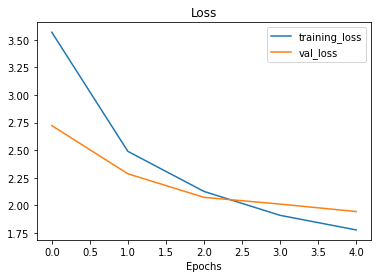

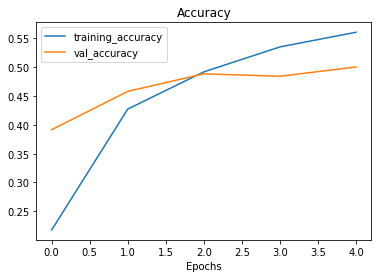

In [14]:
plot_loss_curves(history_all_classes_10_percent)

## Fune-tuning

In [15]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [16]:
# Recompile the model with lower learning rate
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [17]:
# What layers are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)



input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [18]:
# Which layers in base_model are trainable
for number, layer in enumerate(model.layers[2].layers):
  print(number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [19]:
 fine_tune_epoch = 10
 history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                      epochs=fine_tune_epoch,
                                                      validation_data=test_data,
                                                      validation_steps=int(0.15*len(test_data)),
                                                      initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 85s 319ms/step - loss: 1.5207 - accuracy: 0.6075 - val_loss: 1.8982 - val_accuracy: 0.5079
Epoch 6/10
237/237 [==============================] - 72s 301ms/step - loss: 1.4063 - accuracy: 0.6337 - val_loss: 1.9033 - val_accuracy: 0.4997
Epoch 7/10
237/237 [==============================] - 67s 283ms/step - loss: 1.3338 - accuracy: 0.6562 - val_loss: 1.9098 - val_accuracy: 0.5048
Epoch 8/10
237/237 [==============================] - 64s 267ms/step - loss: 1.2741 - accuracy: 0.6638 - val_loss: 1.8550 - val_accuracy: 0.5172
Epoch 9/10
237/237 [==============================] - 64s 269ms/step - loss: 1.1978 - accuracy: 0.6782 - val_loss: 1.8590 - val_accuracy: 0.5169
Epoch 10/10
237/237 [==============================] - 63s 263ms/step - loss: 1.1414 - accuracy: 0.6982 - val_loss: 1.8503 - val_accuracy: 0.5209


In [20]:
model.evaluate(test_data)

790/790 [==============================] - 100s 127ms/step - loss: 1.6948 - accuracy: 0.5551


[1.6948374509811401, 0.5550891160964966]

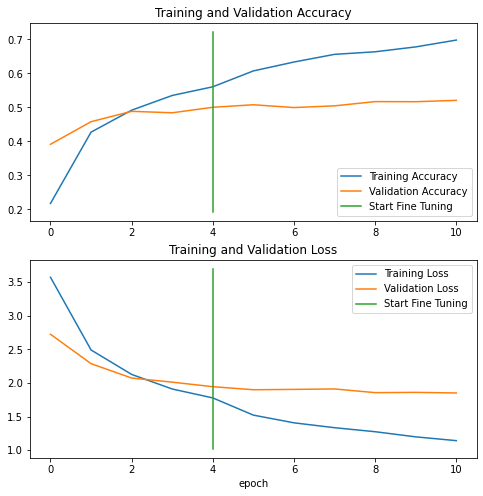

In [21]:
# Compare histories of feature extraction model with fine-tuning
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune)

## Savig and loading our model

To use our model in an external application, we need to save and export it somewhere

In [22]:
 model.save("drive/MyDrive/tensorflow/models/101_food_classes_10_percent_saved_big_dog_model", save_format="h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## Evaluating the performance of our big dog model with different classes

Let's make some perdictions and find out for which classes our model is not performing very well.

In [23]:
 import tensorflow as tf
 !wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-01-19 12:40:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.147.128, 142.250.125.128, 142.250.136.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.147.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   131MB/s    in 0.3s    

2022-01-19 12:40:44 (131 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [24]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [25]:
# Load the model
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [26]:
model.evaluate(test_data)

790/790 [==============================] - 104s 130ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

## Making predictions with our trained model

In [27]:
preds_prob = model.predict(test_data, verbose=1) # setting verbose to see how long is left

790/790 [==============================] - 95s 119ms/step


In [28]:
 len(preds_prob)

25250

In [29]:
preds_prob.shape

(25250, 101)

In [30]:
print(f"No of prediction probability we get for a sample: {len(preds_prob[0])}")
print(f"What prediction probability for sample 0 looks like:\n {preds_prob[0]}")
print(f"The class with highest prediction probability by model for sample 0: {preds_prob[0].argmax()}")
print(f"The classname with highest prediction probability: {test_data.class_names[preds_prob[0].argmax()]}")

No of prediction probability we get for a sample: 101
What prediction probability for sample 0 looks like:
 [5.9541941e-02 3.5742332e-06 4.1376889e-02 1.0660903e-09 8.1613996e-09
 8.6639682e-09 8.0926134e-07 8.5652442e-07 1.9858850e-05 8.0977554e-07
 3.1727692e-09 9.8673388e-07 2.8532100e-04 7.8049661e-10 7.4230990e-04
 3.8915794e-05 6.4740016e-06 2.4977169e-06 3.7891397e-05 2.0678806e-07
 1.5538471e-05 8.1506892e-07 2.6230925e-06 2.0010653e-07 8.3827712e-07
 5.4215743e-06 3.7391112e-06 1.3150788e-08 2.7761345e-03 2.8051816e-05
 6.8561651e-10 2.5574524e-05 1.6688934e-04 7.6409645e-10 4.0452869e-04
 1.3150487e-08 1.7957433e-06 1.4448400e-06 2.3062853e-02 8.2465459e-07
 8.5366531e-07 1.7138503e-06 7.0526130e-06 1.8402382e-08 2.8553984e-07
 7.9482870e-06 2.0682012e-06 1.8525193e-07 3.3619781e-08 3.1522335e-04
 1.0410886e-05 8.5448306e-07 8.4741890e-01 1.0555387e-05 4.4094719e-07
 3.7404192e-05 3.5306137e-05 3.2489079e-05 6.7313988e-05 1.2852399e-08
 2.6220215e-10 1.0318094e-05 8.5742751e-

In [31]:
# Get highest prob pred classes for all the samples
pred_classes = preds_prob.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [32]:
# How many pred classes we have
len(pred_classes)

25250

In [33]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## Evaluating our models prediction

One way to check that our model's prediction array is in same order as our label array is using accuracy score

In [34]:
# Let's try sckitlearn's accuracy score function
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6077623762376237

## Let's get visual: making a confusion matrix

In [35]:
from helper_functions import make_confusion_matrix

# Get list of class names
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

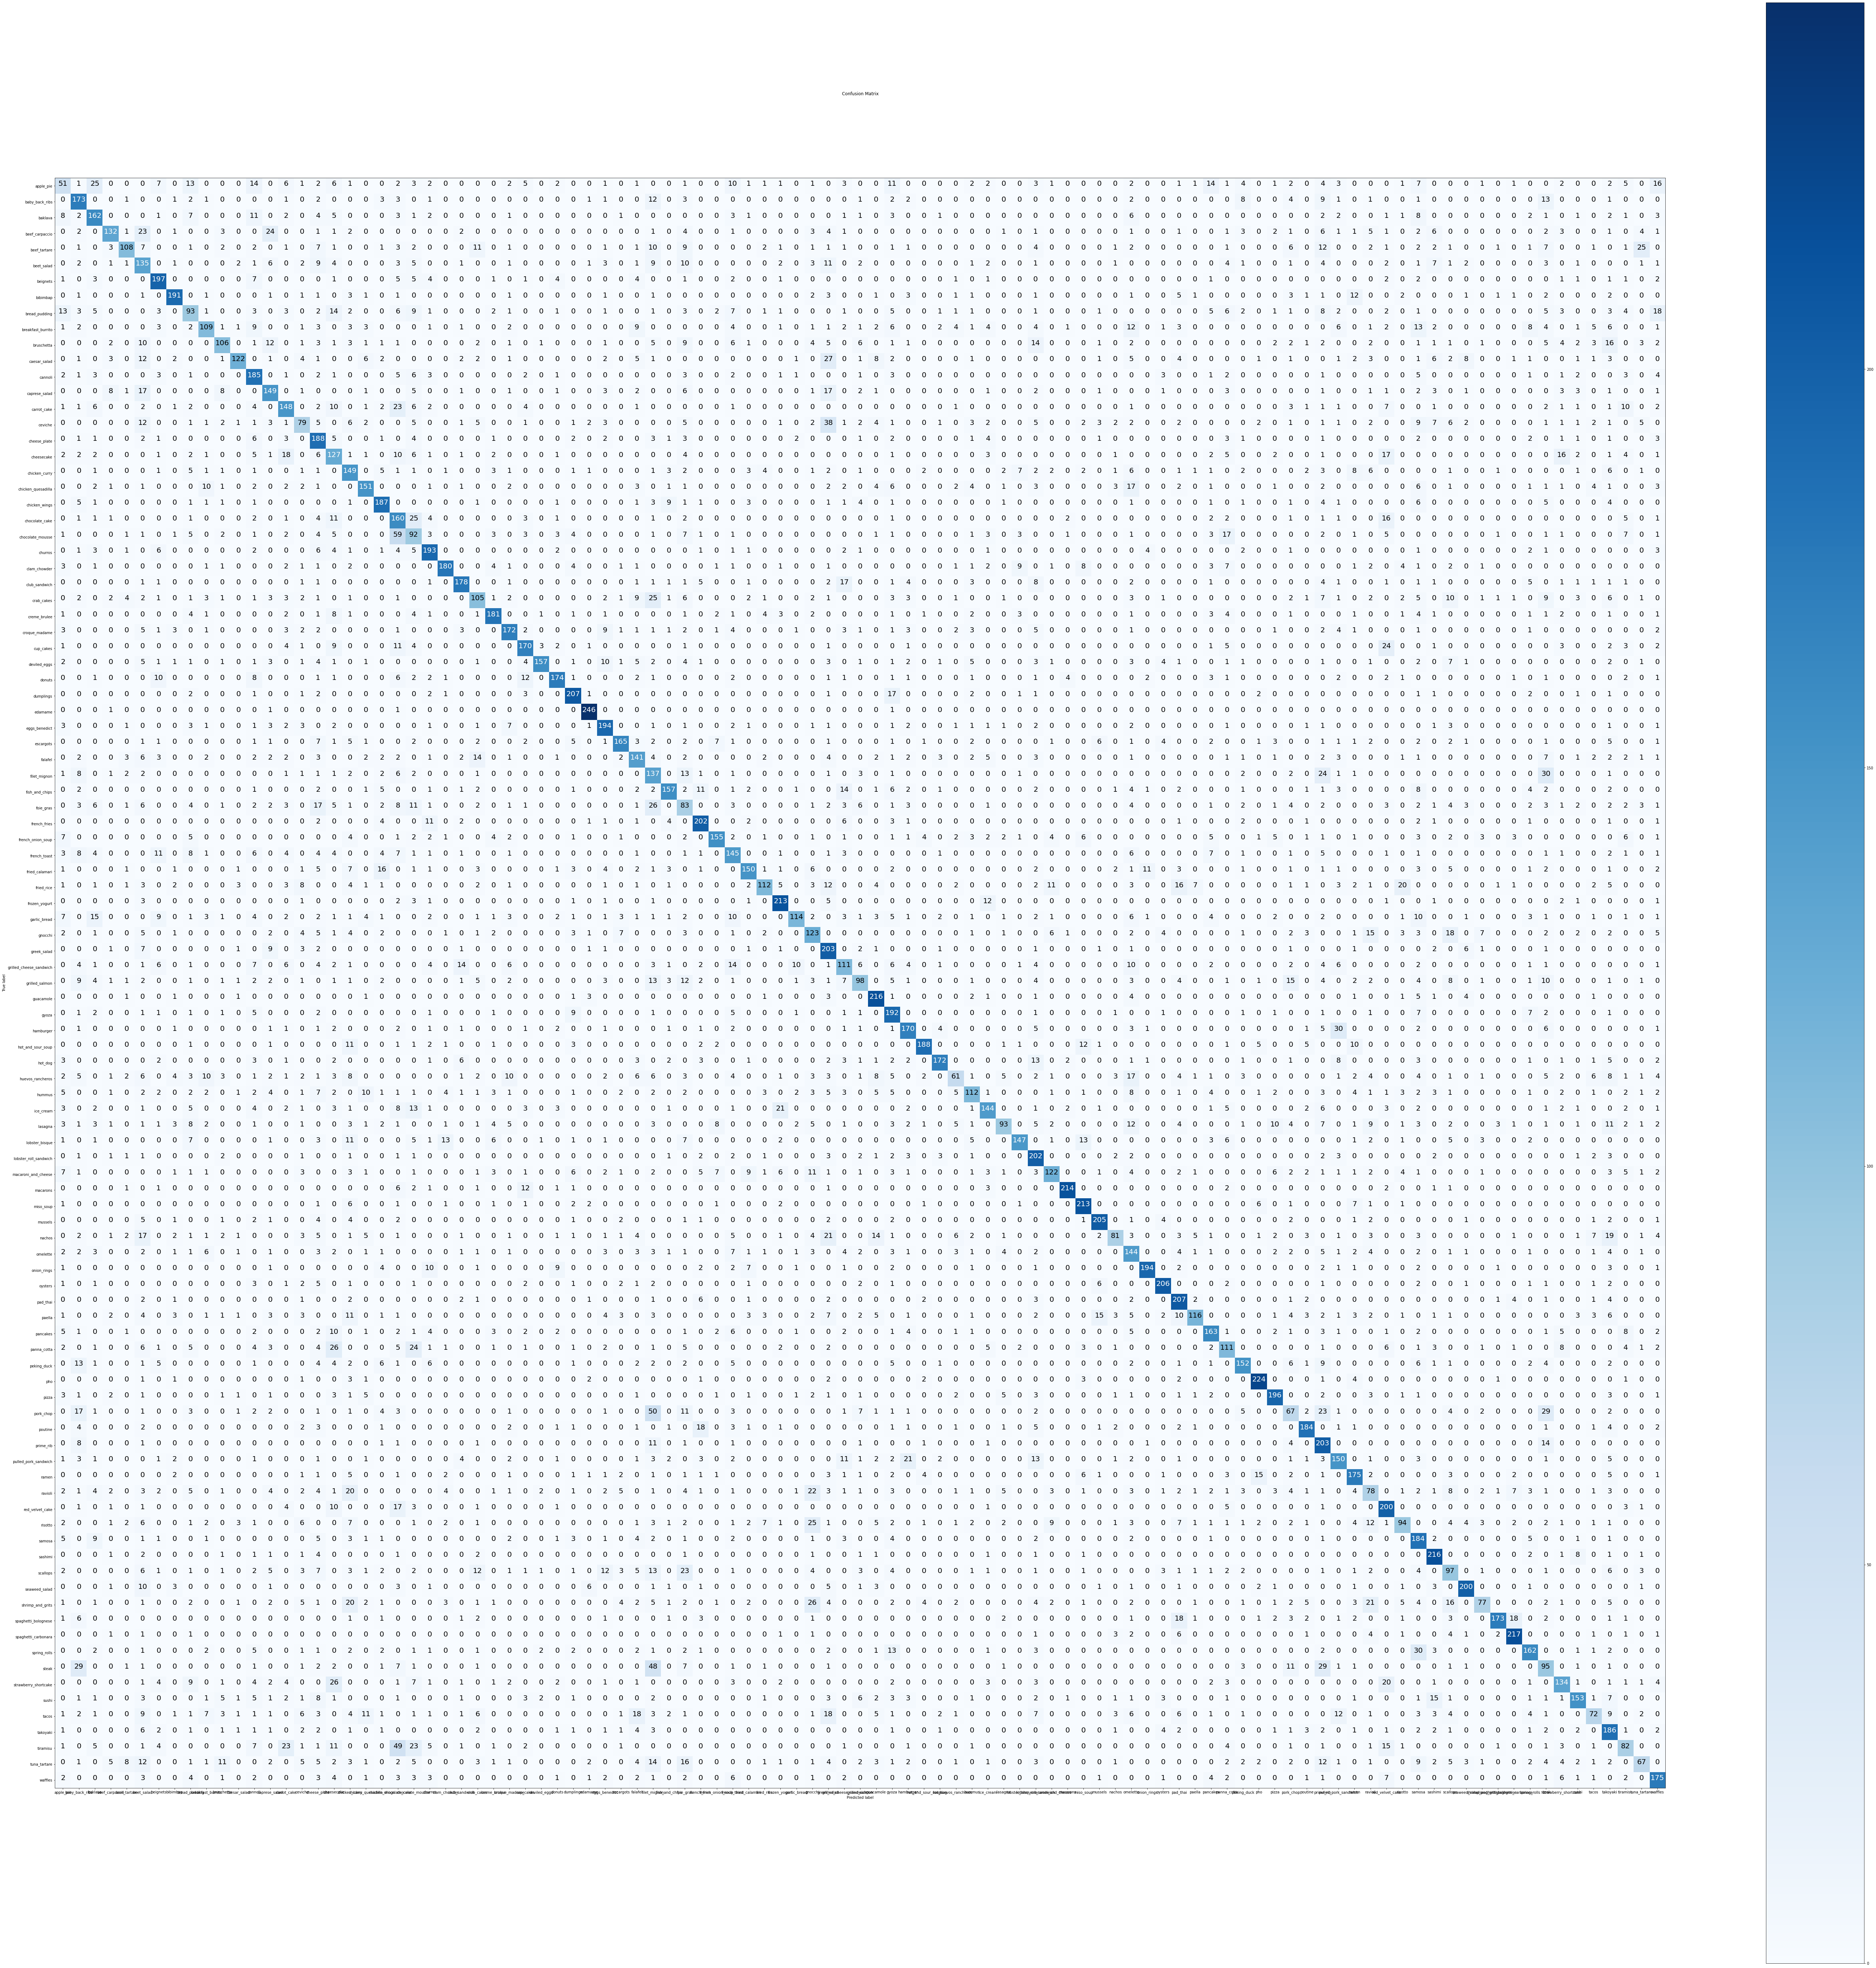

In [36]:
make_confusion_matrix(y_labels, pred_classes, class_names, figsize=(100,100), text_size=20)

 ## Time for classification report

In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

How about we create a visualization of above report

In [38]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'f1-score': 0.24056603773584903,
  'precision': 0.29310344827586204,
  'recall': 0.204,
  'support': 250},
 '1': {'f1-score': 0.5864406779661017,
  'precision': 0.5088235294117647,
  'recall': 0.692,
  'support': 250},
 '10': {'f1-score': 0.5047619047619047,
  'precision': 0.6235294117647059,
  'recall': 0.424,
  'support': 250},
 '100': {'f1-score': 0.641025641025641,
  'precision': 0.5912162162162162,
  'recall': 0.7,
  'support': 250},
 '11': {'f1-score': 0.6161616161616161,
  'precision': 0.8356164383561644,
  'recall': 0.488,
  'support': 250},
 '12': {'f1-score': 0.6105610561056106,
  'precision': 0.5196629213483146,
  'recall': 0.74,
  'support': 250},
 '13': {'f1-score': 0.5775193798449612,
  'precision': 0.5601503759398496,
  'recall': 0.596,
  'support': 250},
 '14': {'f1-score': 0.574757281553398,
  'precision': 0.5584905660377358,
  'recall': 0.592,
  'support': 250},
 '15': {'f1-score': 0.36744186046511623,
  'precision': 0.4388888888888889,
  'recall': 0.316,
  'su

Let' plot all of our classes f1 score

In [39]:
# Create an empty dict
class_f1_scores = {}

# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    # Add class names and f1 scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [40]:
# Turn f1-scores into a dataframe to visualize it
import pandas as pd
f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                          "f1_scores":list(class_f1_scores.values())}).sort_values("f1_scores", ascending=False)
f1_scores

,class_names,f1_scores
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
...,...,...
56,huevos_rancheros,0.339833
22,chocolate_mousse,0.329159
77,pork_chop,0.308756
39,foie_gras,0.297491


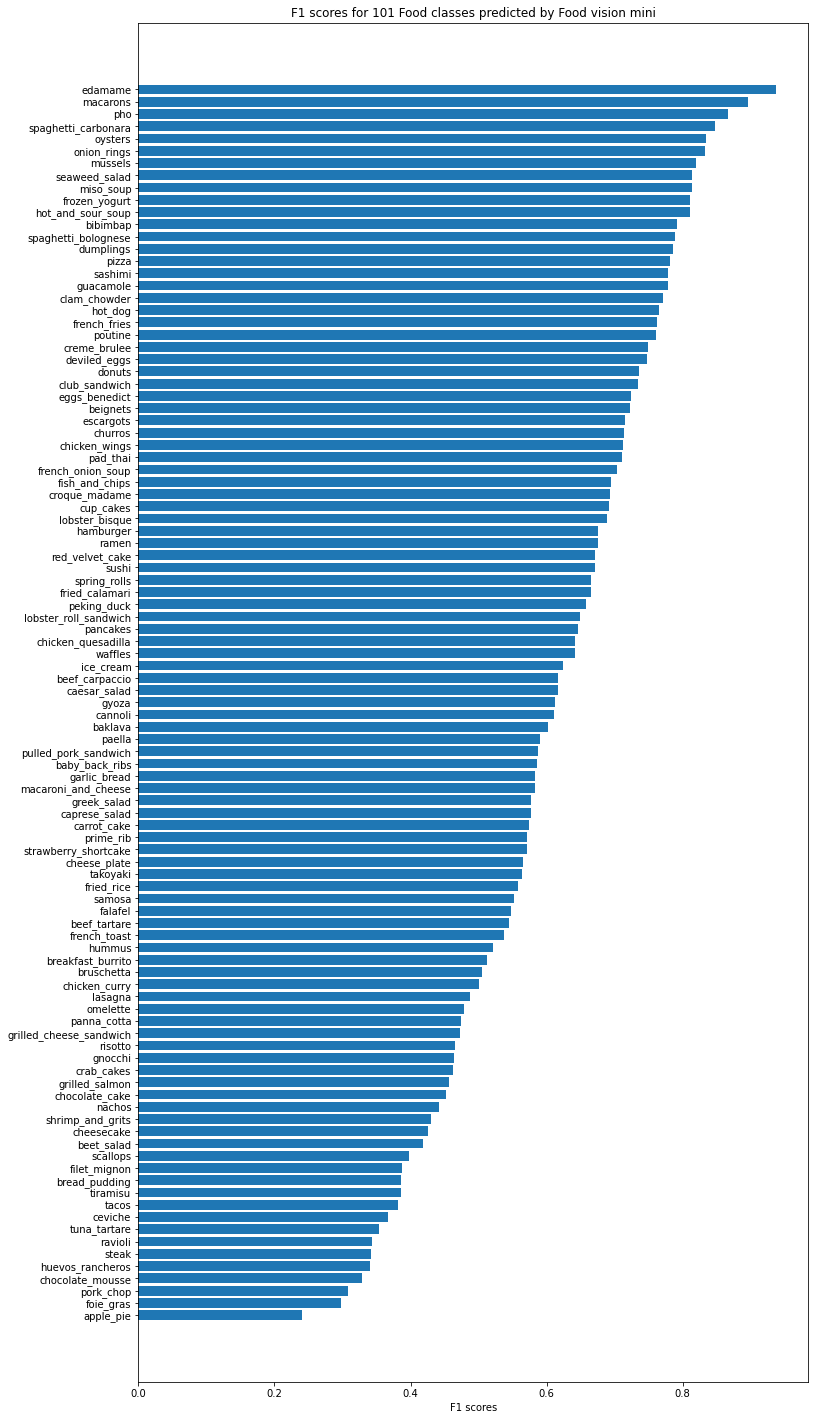

In [41]:
import matplotlib.pyplot as plt
fig , ax = plt.subplots(figsize=(12,25))
scores = plt.barh(range(len(f1_scores)), f1_scores["f1_scores"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1 scores")
ax.set_title("F1 scores for 101 Food classes predicted by Food vision mini")
ax.invert_yaxis() # Reverse the order of classes (higher f1 scores in top)


## Visualizing predicions on custom data

We will have to create function which will load and preprocess the images, specifically it will need to:
* Read in a target image filepath using tf.io.readfile()
* Turn the image in to a tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the size of the images our model got trained on using tf.image.resize()
* Scale the image to get all the pixel values between 0 and 1 (if neccessary)

In [42]:
# Create a fucntion to load and prepare the images
def load_prepare_images(filename, img_shape=224, scale=True):
  """
  Reads in an image from a filename, turns it into tensors and reshapes into specific shapes (img_shape, img_shape, 3(color channels))

  Args:
    filename (str): path to target image
    img_shape (int): height/width of target image size
    scale (bool): scale pixel values from 0-255 to 0-1
  
  Returns:
    Image tensor of shape (img_shape, img_shape, 3)
  """
  # Read the image 
  img = tf.io.read_file(filename)

  # Decode the image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])

  # Scale? Yes/No
  if scale == True:
    return img/255.
  else:
    return img

Let's write some code to visualize images, their target label and our model's perdictions.

Specifically we will write code to:
1. Load some random images form test dataset.
2. Make predictions on loaded images.
3. Plot the loaded image, prediction label, prediction probability, truth label

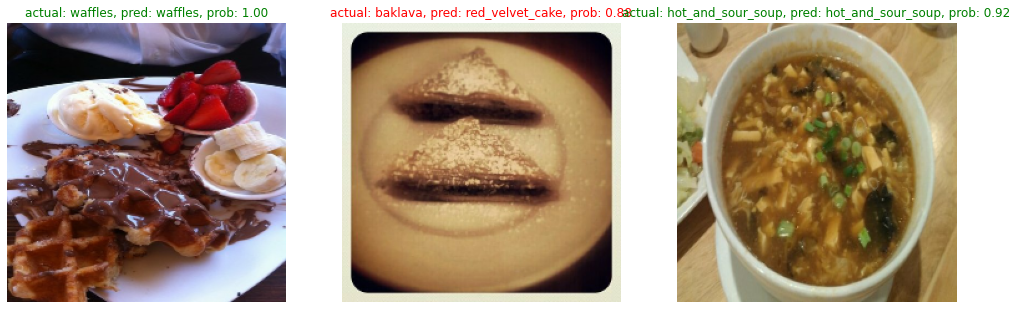

In [43]:
# Make predictions on series of random images
import os 
import random

plt.figure(figsize=(17,10))
for i in range(3):
  # Choose a random image(s) from a random class(es)
  class_name = random.choice(class_names)
  file_name = random.choice(os.listdir(test_dir + "/" + class_name))
  file_path = (test_dir + "/" + class_name + "/" + file_name)
  
  # Load the image and make predictions
  img = load_prepare_images(file_path, scale=False)
  img_expanded = tf.expand_dims(img, axis=0) # expanding the dims from (224, 224, 3) to (1, 224, 224, 3) as the model is trained with later shape
  #print(img_expanded.shape)
  pred_prob = model.predict(img_expanded)
  pred_class = class_names[pred_prob.argmax()]
  #print(pred_prob)
  #print(pred_class)

  # Plot image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.) # dividing by 255 as plt needs values between 0 and 1
  if class_name == pred_class:
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False)

## Finding wrong predictions with high prediction probability

Let's write some code to find out the following:
1. Get all the file paths in the test dataset using listdir() method.
2. Create pandas Dataframe with image filepaths, actual labels, predicted labels, pred probability.
3. Use our DataFrame to find all the wrong predictions
4. Sort the dataframe based on wrong predictions with highest pred probability.
5. Visualize images with wrong prediction and highest probability.

In [44]:
# 1. Get all the file paths inthe test dataset
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]


[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [45]:
 # 2. Create dataframe
 import pandas as pd
 pred_df = pd.DataFrame({
     "img_path" : filepaths,
     "y_true" : y_labels,
     "y_pred" : pred_classes,
     "pred_conf" : preds_prob.max(axis=1),
     "y_true_classname" : [class_names[i] for i in y_labels],
     "y_pred_classname" : [class_names[i] for i in pred_classes]  
 })

In [46]:
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,b'/content/101_food_classes_10_percent/test/ap...,0,52,0.847419,apple_pie,gyoza
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.964017,apple_pie,apple_pie
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.959259,apple_pie,apple_pie
3,b'/content/101_food_classes_10_percent/test/ap...,0,80,0.658607,apple_pie,pulled_pork_sandwich
4,b'/content/101_food_classes_10_percent/test/ap...,0,79,0.367902,apple_pie,prime_rib


In [47]:
# 3. Find the wrong predictions
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,b'/content/101_food_classes_10_percent/test/ap...,0,52,0.847419,apple_pie,gyoza,False
1,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.964017,apple_pie,apple_pie,True
2,b'/content/101_food_classes_10_percent/test/ap...,0,0,0.959259,apple_pie,apple_pie,True
3,b'/content/101_food_classes_10_percent/test/ap...,0,80,0.658607,apple_pie,pulled_pork_sandwich,False
4,b'/content/101_food_classes_10_percent/test/ap...,0,79,0.367902,apple_pie,prime_rib,False


In [49]:
# 4. Sort our dataframe based on most wrong preds with highest probability
top_100_wrong = pred_df[pred_df["pred_correct"]== False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong[:20]

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
21810,b'/content/101_food_classes_10_percent/test/sc...,87,29,0.999997,scallops,cup_cakes,False
231,b'/content/101_food_classes_10_percent/test/ap...,0,100,0.999995,apple_pie,waffles,False
15359,b'/content/101_food_classes_10_percent/test/lo...,61,53,0.999988,lobster_roll_sandwich,hamburger,False
23539,b'/content/101_food_classes_10_percent/test/st...,94,83,0.999987,strawberry_shortcake,red_velvet_cake,False
21400,b'/content/101_food_classes_10_percent/test/sa...,85,92,0.999981,samosa,spring_rolls,False
24540,b'/content/101_food_classes_10_percent/test/ti...,98,83,0.999947,tiramisu,red_velvet_cake,False
2511,b'/content/101_food_classes_10_percent/test/br...,10,61,0.999945,bruschetta,lobster_roll_sandwich,False
5574,b'/content/101_food_classes_10_percent/test/ch...,22,21,0.999939,chocolate_mousse,chocolate_cake,False
17855,b'/content/101_food_classes_10_percent/test/pa...,71,65,0.999931,paella,mussels,False
23797,b'/content/101_food_classes_10_percent/test/su...,95,86,0.999904,sushi,sashimi,False


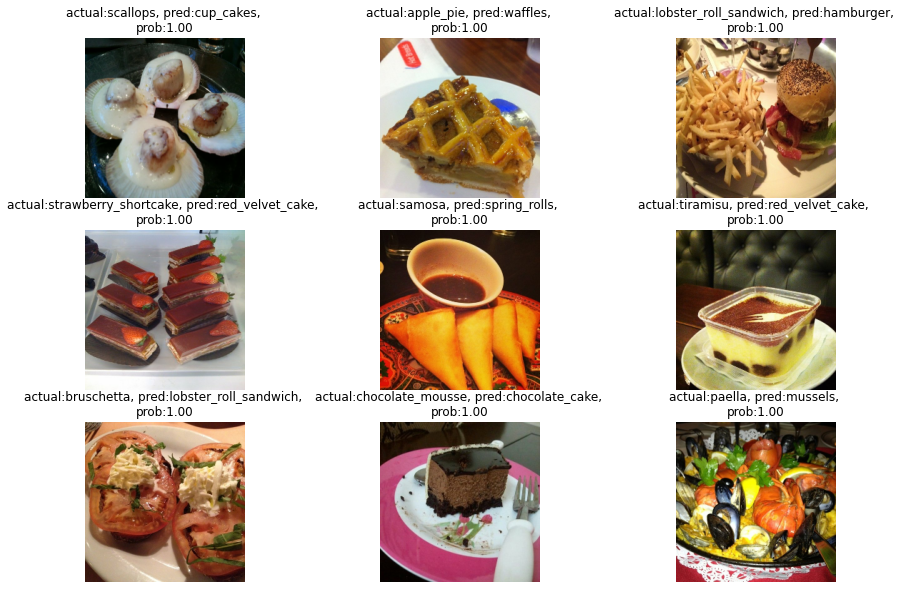

In [53]:
# Visualize the test data sample which have wrong predictions but high pred probability
images_to_view = 9
start_index = 0
plt.figure(figsize=(15,10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_prepare_images(row[1], scale=True)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname, _ = row
  plt.imshow(img)
  plt.title(f"actual:{y_true_classname}, pred:{y_pred_classname}, \nprob:{pred_prob:.2f}")
  plt.axis(False)


## Test the model on our own custom images 

In [55]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
unzip_data("custom_food_images.zip")

--2022-01-19 13:09:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 173.194.195.128, 142.250.152.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip.1’

custom_food_images. 100%[===================>]  12.58M  --.-KB/s    in 0.06s   

2022-01-19 13:09:20 (219 MB/s) - ‘custom_food_images.zip.1’ saved [13192985/13192985]



In [56]:
# Get the filepaths of the custom food images
custom_food_images = ["custom_food_images/" + imgpath for imgpath in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/steak.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/ramen.jpeg',
 'custom_food_images/sushi.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg']

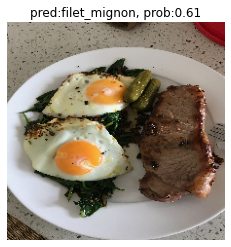

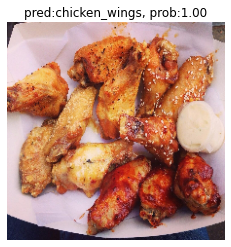

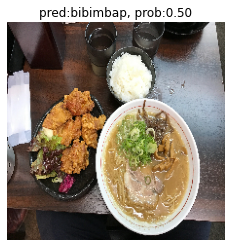

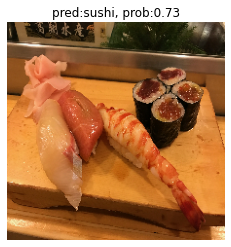

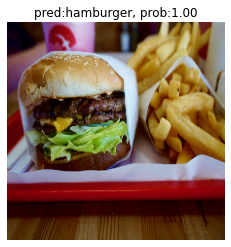

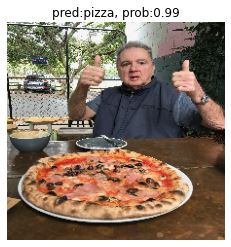

In [59]:
for img in custom_food_images:
  img = load_prepare_images(img, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0))
  pred_class = class_names[pred_prob.argmax()]

  # Plot the image and result
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred:{pred_class}, prob:{pred_prob.max():.2f}")
  plt.axis(False)